In [1]:
%matplotlib inline

from umachine_pyio.load_mock import value_added_mock, load_mock_from_binaries
subvolumes = np.random.choice(np.arange(144), 50, replace=False)
galprops = ('upid', 'obs_sfr', 'icl', 'sfr_history_main_prog', 'mpeak', 
            'sfr', 'halo_id', 'mvir', 'rvir', 'vx', 'sm', 'vy', 'y', 
           'x', 'sm_history_main_prog', 'z', 'vz', 'obs_sm','dvmax_zscore_history')
vamock = value_added_mock(load_mock_from_binaries(subvolumes, galprops=galprops), 250)
print(vamock.keys())
sfrh, smh = vamock['sfr_history_main_prog'].data, vamock['sm_history_main_prog'].data
sm = np.log10(vamock['obs_sm'].data)
ssfr = np.log10(vamock['obs_sfr'].data/vamock['obs_sm'].data)
from umachine_pyio.load_mock import get_snapshot_times
cosmic_age_array = get_snapshot_times()
zobs = 0.

In [2]:
%load_ext Cython

In [21]:
%%cython 

cimport cython
import numpy as np
cimport numpy as cnp
from empirical_disk_bulge.models.sfr_integration import (_stellar_mass_integrand_factors,
        _index_of_nearest_larger_redshift, bolplanck_redshifts)
from libc.math cimport fmax as c_fmax
from libc.stdlib cimport rand as c_rand
from libc.stdlib cimport RAND_MAX


cdef double random_uniform():
    cdef double r = c_rand()
    return r/RAND_MAX

__all__ = ('custom_merger_triggered_disruption_engine', )


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def custom_merger_triggered_disruption_engine(double[:, :] in_situ_sfr_history,
        double[:, :] dsm_main_prog,
        double[:, :] merger_threshold_history,
        cosmic_age_array, redshift_obs, double frac_migration,
        return_disruption_history=False, return_formation_histories=False):
    """
    """
    #  dt_arr stores the array of time steps
    #  frac_remaining_arr the mass loss fraction due to stellar evolution
    idx_zobs = _index_of_nearest_larger_redshift(redshift_obs, bolplanck_redshifts)
    _dt, _frac_remaining = _stellar_mass_integrand_factors(
            cosmic_age_array[idx_zobs], cosmic_age_array)
    cdef double[:] dt_arr = np.array(_dt, dtype='f8', order='C')
    cdef double dt
    cdef double[:] frac_remaining_arr = np.array(_frac_remaining, dtype='f8', order='C')
    cdef double frac_remaining

    #  Determine shape of the star-formation histories
    cdef int num_gals = in_situ_sfr_history.shape[0]
    cdef int num_time_steps = in_situ_sfr_history.shape[1]

    #  Declare output array and loop variables
    cdef double[:, :] disk_bulge_result = np.zeros((num_gals, 2), dtype='f8', order='C')
    cdef double[:, :] disruption_history = np.zeros_like(in_situ_sfr_history, dtype='f8', order='C')
    cdef double sm_bulge, sm_disk, dsm_mergers, sm_tot
    cdef int igal, itime

    cdef double[:, :] dsm_merger_history = np.zeros_like(in_situ_sfr_history, dtype='f8', order='C')
    cdef double[:, :] sm_disk_history = np.zeros_like(in_situ_sfr_history, dtype='f8', order='C')

    #  Declare variables needed by the model
    cdef double merging_dsm, in_situ_dsm, merger_thresh


    #  Outer loop is over rows, one for each galaxy in the mock
    for igal in range(num_gals):
        sm_bulge = 0.
        sm_disk = 0.

        #  Inner loop is over columns, one for every timestep
        for itime in range(num_time_steps):

            #  Retrieve the amount of time that has passed between snapshots
            dt = dt_arr[itime]

            #  Retrieve the (pre-computed) amount of fractional stellar mass loss
            frac_remaining = frac_remaining_arr[itime]

            #  Add all in-situ SFR into the disk
            in_situ_dsm = in_situ_sfr_history[igal, itime]*dt*1e9
            sm_disk += in_situ_dsm*frac_remaining

            #  Add all mergers into the bulge
            dsm_mergers = dsm_main_prog[igal, itime] - in_situ_dsm
            sm_bulge += c_fmax(0., dsm_mergers*frac_remaining)

            #  Store merger & disk history
            dsm_merger_history[igal, itime] = dsm_mergers
            sm_disk_history[igal, itime] = sm_disk

            #  Disrupt the disk according to the merger threshold
            merger_thresh = merger_threshold_history[igal, itime]
            if (dsm_mergers > merger_thresh*sm_disk):
                disk_to_bulge_migration_mass = frac_migration*sm_disk
                sm_bulge += disk_to_bulge_migration_mass
                sm_disk -= disk_to_bulge_migration_mass
                disruption_history[igal, itime] = disk_to_bulge_migration_mass

        #  Update the output arrays before moving on to the next galaxy
        disk_bulge_result[igal, 0] = sm_disk
        disk_bulge_result[igal, 1] = sm_bulge

    if return_formation_histories:
        return disk_bulge_result, np.array(disruption_history), np.array(dsm_merger_history), np.array(sm_disk_history)
    elif return_disruption_history:
        return disk_bulge_result, disruption_history
    else:
        return disk_bulge_result


In [29]:
def custom_merger_triggered_disruption(sfr_history, sm_history, merger_threshold_history,
        cosmic_age_array, zobs, frac_migration, return_disruption_history=False, 
                                      return_formation_histories=False):
    """
    """
    dsm_history = np.insert(np.diff(sm_history), 0, sm_history[:, 0], axis=1)

    _engine_output = custom_merger_triggered_disruption_engine(
            sfr_history, dsm_history, merger_threshold_history,
                cosmic_age_array, zobs, frac_migration,
                return_disruption_history=return_disruption_history, 
                return_formation_histories=return_formation_histories)

    if return_formation_histories:
        disk_bulge_decomposition, disruption_history, dsm_merger_history, sm_disk_history = _engine_output
        disk_bulge_array = np.array(disk_bulge_decomposition)
        sm_disk, sm_bulge = disk_bulge_array[:, 0], disk_bulge_array[:, 1]
        return sm_disk, sm_bulge, np.array(disruption_history), dsm_merger_history, sm_disk_history
    elif return_disruption_history:
        disk_bulge_decomposition, disruption_history = _engine_output
        disk_bulge_array = np.array(disk_bulge_decomposition)
        sm_disk, sm_bulge = disk_bulge_array[:, 0], disk_bulge_array[:, 1]
        return sm_disk, sm_bulge, np.array(disruption_history)
    else:
        disk_bulge_array = np.array(_engine_output)
        sm_disk, sm_bulge = disk_bulge_array[:, 0], disk_bulge_array[:, 1]
        return sm_disk, sm_bulge

def merger_model_prediction(params, sm, ssfr, smh, sfrh, muh, tarr):
    frac_migration,  = params

    zobs = 0.
    sm_disk, sm_bulge, disruption_history = custom_merger_triggered_disruption(sfrh, smh, muh, 
                                                tarr, zobs, frac_migration, 
                                                 return_disruption_history=True)
    bt = sm_bulge/(sm_disk + sm_bulge)
    
    return bt_measurement(bt, sm, ssfr, return_data_vector=False), disruption_history


In [30]:
muh = np.zeros_like(sfrh) + 0.01
frac_migration = 0.35

sm_disk, sm_bulge, disruption_history, dsm_merger_history, sm_disk_history = custom_merger_triggered_disruption(sfrh, smh, muh, 
                                                cosmic_age_array, zobs, frac_migration, 
                                                 return_formation_histories=True)

In [31]:
muh = np.where(sm_disk_history>0, dsm_merger_history/sm_disk_history, 0)

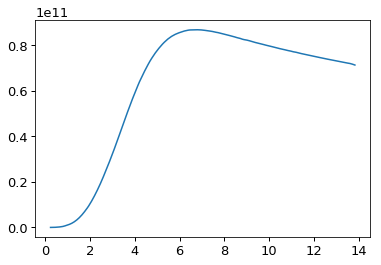

In [41]:
fig, ax = plt.subplots(1, 1)

mask = vamock['sm'] > 10**11
__=ax.plot(cosmic_age_array, np.mean(sm_disk_history[mask], axis=0))

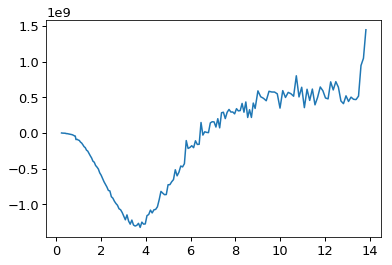

In [45]:
fig, ax = plt.subplots(1, 1)

mask = vamock['sm'] > 10**11
__=ax.plot(cosmic_age_array, np.mean(dsm_merger_history[mask], axis=0))